In [3]:

import tkinter as tk
import tkinter.ttk
from tkinter import filedialog
from PIL import ImageTk, Image
import numpy as np
import cv2
from sklearn.decomposition import PCA
from radiomics import featureextractor
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
from scipy.spatial.transform import Rotation as R



In [4]:
import numpy as np
import tables as tb


total_slices = 155
number_of_patents = 50
glioma_masks = []
glioma_images = []

for volume_index in range(number_of_patients):
    glioma_slices_masks = []
    glioma_slices_images = []
    for slice_index in range(total_slices):
        # Load the mask and image from the H5 file
        with tb.open_file(f"data/volume_{volume_index + 1}_slice_{slice_index}.h5", mode="r") as h5_file:
            
            next_glioma_mask = h5_file.root.mask.read()
            next_glioma_image = h5_file.root.image.read()
        
        # Append the mask and image to the lists
        glioma_slices_masks.append(next_glioma_mask)
        glioma_slices_images.append(next_glioma_image)
    glioma_masks.append(np.array(glioma_slices_masks))
    glioma_images.append(np.array(glioma_slices_images))
    print("Finished volume_" + str(volume_index +1))
glioma_masks = np.array(glioma_masks)
glioma_images = np.array(glioma_images)

Finished volume_1
Finished volume_2
Finished volume_3
Finished volume_4
Finished volume_5
Finished volume_6
Finished volume_7
Finished volume_8
Finished volume_9
Finished volume_10
Finished volume_11
Finished volume_12
Finished volume_13
Finished volume_14
Finished volume_15
Finished volume_16
Finished volume_17
Finished volume_18
Finished volume_19
Finished volume_20
Finished volume_21
Finished volume_22
Finished volume_23
Finished volume_24
Finished volume_25
Finished volume_26
Finished volume_27
Finished volume_28
Finished volume_29
Finished volume_30
Finished volume_31
Finished volume_32
Finished volume_33
Finished volume_34
Finished volume_35
Finished volume_36
Finished volume_37
Finished volume_38
Finished volume_39
Finished volume_40
Finished volume_41
Finished volume_42
Finished volume_43
Finished volume_44
Finished volume_45
Finished volume_46
Finished volume_47
Finished volume_48
Finished volume_49
Finished volume_50


In [5]:
print(glioma_masks.shape)
print(glioma_images.shape)

(50, 155, 240, 240, 3)
(50, 155, 240, 240, 4)


In [6]:
print(glioma_masks[0].shape, glioma_masks[0][0].shape)

(155, 240, 240, 3) (240, 240, 3)


In [66]:
class Extraction():
    def __init__(self, image, mask, volume_index) -> None:
        self.image = image
        self.mask = mask
        self.volume_index = volume_index

    # Function to create a merged mask from the list of masks uploaded from the dataset
    # returns the merged mask
    def merge_masks2(self,mask_array):
        # merge non-overlapping masks by addition
        merge_one = mask_array[:,:,0] + mask_array[:,:,1] + mask_array[:,:,2]
        return merge_one
    
    # Function to determine the maximum tumour area present in a slice of an idividual MRI Volume 
    def Maximum_tumout_area(self):
        # set the number  of slices in a volume, set an empty list to accumulate all the glioma volume in voxels
        no_slices=self.mask.shape[0]
        slices_count= []

        # Loop over all slices calulating the glioma volume in each slice
        for slice in range(no_slices):
            #set the slice count to zero
            slice_count = 0

            # Obtain the image of the three masks collectively containing the whole tumour in one image 
            merged_mask = self.merge_masks2(self.mask[slice,:,:,:])
            voxel_count = np.count_nonzero(merged_mask > 0) #calculate the number of  non zero voxels in the image of the glioma

            #Append the voxel count to a list
            slices_count.append(voxel_count)
        return slices_count



    # Determine the maximum diameter of the tumour in a volume using Principle Component Analysis (PCA)
    # take as a parameter all 3 masks dowloaded from Kaggle and returns a list of the diqmeters of the tumor for each slice.
    def tumour_diameter(self):
        # create a PCA object (no of components is one which returns the variance for only one eigenvector), 
        # and list to store the tumor diameter for a slice
        glioma_pca = PCA(n_components=1)
        slices_diameter = []
        
        # loop to determine the standard deviation, from PCA, as an approximation to the radius for eaxch slice of a volume
        for slice in range(total_slices):
        
            # create list to transform x and y co-ordinates in the mask image (mask image is binarized) 
            # to a list of x and y co-ordinates of pixels in the image having a value of 1.
            mask_newaxis = []
        
            # call merge_mask2 to return an image of the overlayed masks
            merged_mask = self.merge_masks2(self.mask[slice,:,:,:])
        
            # Transform the x and y coordinates in the image into a list of lists where the nested list contains the x any y 
            # co-ordinates in the image of all pixels whose value is 1.
            for x in range(merged_mask.shape[0]):
                for y in range(merged_mask.shape[1]):
                    if merged_mask[x,y] == 1:
                        mask_newaxis.append([x,y])
                    elif merged_mask[x,y] == 0:
                        continue
        
            # if no tumour is detected in the mask (ie no value of 1) then append 0 to the list of radius length for that slice
            if len(mask_newaxis) == 0:
                slices_diameter.append(0)
                continue
        
            # fit the tranformed x and y co-ordinates to the PCA object and get the variance
            glioma_pca.fit(mask_newaxis)
            variance = glioma_pca.explained_variance_
        
            # Append the diameter to the diameters list as twice the radius
            slices_diameter.append((variance[0]**0.5)*2)

        return slices_diameter



    # Function to transform the list of x and y co-ordinates returned by the openCV findContours method
    # into their corresponding pixels on an image, ie create a new image wioth the contour displayed in 2D
    def transform_contour(self,contours):
        # Set the width and height of the image to be created, and create a blank image of zeroes
        image_w=240
        image_h=240
        contour_image = np.zeros((image_w,image_h))

        # Loop over all the x and y co-ordinates in the co-ordinate list, Set the corresponding x and y
        # co-ordinates to 255, ie produce a white contour on a black background (binary image)
        for contour in range(len(contours[0])):
            contour_image[contours[0][contour][0][1],contours[0][contour][0][0]]=255
        
        # Return the image of the contour
        return contour_image

    # Function to produce a contour 5 pixels in width, of the brain (cerebral cortex), by producing a contour of the brain
    # within a slice; storing the image of the contour; then subtracting this contour from the original image and producing
    # another contour from the reduced image; then adding this image to the original contour. This process is repeated unitl 
    # the image of the stored contours consists of 5 contours, hence being 5 pixels wide,
    def merge_contours(self,image):
        #set variables for the width and height of the image, and the number or layers required for the combined contour
        image_w=240
        image_h=240
        outer_layers = 5

        # Convert the greyscale image of the brain into a binarized format, with all values above zero
        # set to 255 ie the brain matter will turn completeley white creating a sharp contrast at the 
        # border.
        ret, image_th = cv2.threshold(image,0,255, cv2.THRESH_BINARY)

        # convert the image to the correct datatype and create a blank image to store the created contours
        image_uint8 = image_th.astype(np.uint8)
        collected_contours = np.zeros((image_w,image_h))

        
        # Loop to calculate the contours of the brain image (outer contour); accumlate the contours in the
        # one image; subtract the produced contour form the image and repeat the procdedure using the reduced image
        # until 5 layers of contours have been added.
        for cont_num in range(outer_layers):
            # method to return the contours from the openCV findContours method. The parameter RETR_EXTERNAL ensure
            # only co-ordinates of the pixels in the outer contour of the brain image are returned. If no contour is found
            # there is no tumor in the slice the the function continues to process the next slice.
            contours, _ = cv2.findContours(image_uint8,cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
            if len(contours) == 0: continue

            # Call the transform_contours function to return an image of the contour.
            contour_image = self.transform_contour(contours)

            # Add the image of the contour to the blank image and accumulate the remaining 4 cnotours on subsequent loop iterations
            collected_contours += contour_image

            # subtract the contour from the image of the brain to produce a new image reduced in size by one pixel around the edge/perimeter
            # and change the datatype to uint8 to promote continued processing of the image
            reduced_image = image_uint8 - contour_image
            image_uint8 = reduced_image.astype(np.uint8)

        # return the combined image of the contours
        return collected_contours



    # function to determine the maximum volume of the Glioma within a MRI volume, by using a combined mask image of the Glioma
    # as a blocking/filtering mask on an image of the cerrebral cortex. 
    def glioma_cortex_invasion(self):
        # Set the variable to accumulate the numebr of voxels invaded by the glioma in the cerebral cortex across the MRI volume 
        total_voxels = 0

        # loop to process each slice in an MRI volume calculating the glioma occupied part ot the cerebral cortex for each slice
        for slice in range(self.image.shape[0]):
            T1_native = self.merge_contours(self.image[slice,:,:,1]) # get the 5 pixel thick contour of the brain from a slice
            glioma_merged_mask = self.merge_masks2(self.mask[slice,:,:,:]) # Get the image of the merged masks
            glioma_overlap = cv2.bitwise_and(T1_native.astype(np.uint8), glioma_merged_mask) # Return the overlap of the glioma and the cerebral cortex
            voxel_count = np.count_nonzero(glioma_overlap == 1) # calculate the nuber of voxels labelled 1 (the overlap)
            total_voxels += voxel_count
        
        return total_voxels
        


    def radiomic_features(self):
        np.set_printoptions(threshold=np.inf, linewidth=150)
        features_sets = []
        for slice in range(4):
            # Convert the NumPy array to a SimpleITK image
            
            image_array = self.image[:,:,:,slice]
            image = sitk.GetImageFromArray(image_array)

            # Load the segmentation mask using SimpleITK
            
            merged_mask = np.sum(self.mask, axis=-1)
            mask = sitk.GetImageFromArray(merged_mask)

            # Configure the PyRadiomics feature extractor using default parameters
            extractor = featureextractor.RadiomicsFeatureExtractor()
            # Extract radiomic features
            features = extractor.execute(image, mask)
            features_sets.append(features)
        
        # Define column mapping for DataFrame
        column_mapping = {
            0: f'T2-FLAIR_{self.volume_index}',
            1: f'T1_{self.volume_index}',
            2: f'T1Gd_{self.volume_index}',
            3: f'T2_{self.volume_index}'
        }

        rm_features = pd.DataFrame(features_sets).T
        rm_features.rename(columns=column_mapping, inplace=True)
        
        
        return rm_features

    def transform_images(self, transform_function, base="image", *parameters):
        self.transformed_image=np.zeros([155,240,240,4], dtype=np.int64)
        
        if transform_function == "noise": 
            new_vol=self.noise_transform(base)
            return new_vol

        elif transform_function == "rotate":
            angle, scale = 0,1
            angle = parameters[0]
            if len(parameters) >0:
                angle = parameters[0]
            elif len(parameters) >1:
                scale = parameters[1]
            new_vol=self.rotation_transform(base, angle, scale)
            return new_vol

        elif transform_function == "3Drotate":
            x,y,z  = parameters[0],parameters[1],parameters[2]
            angle = parameters[0]
            if len(parameters) >0:
                angle = parameters[0]
            elif len(parameters) >1:
                scale = parameters[1]
            new_vol=self.rotation3D_transform(base, x,y,x)
            return new_vol

        elif transform_function == "scale":
            scale_x = 0.9
            scale_y = 0.9
            if len(parameters) >0:
                    scale_x = parameters[0]
            elif len(parameters) >1:
                scale_y = parameters[1]
            new_vol = self.scale_transform(base, scale_x, scale_y)
            return new_vol

        elif transform_function == "grey":
            new_vol = self.grey_transform(base)
            return new_vol
             
        elif transform_function == "illumination":
            ksize, boosting_factor = parameters[0], parameters[1]
            new_vol = self.illumination_transform(base, ksize, boosting_factor)
            return new_vol
        
        elif transform_function == "affine":
            new_vol = self.affine_transform(base)
            return new_vol

        elif transform_function == "perspective":
            new_vol = self.perspective_transform(base)
            return new_vol

        elif transform_function == "gaussian_blur":
            ksize, sigmax, sigmay = parameters[0], parameters[1], parameters[2]
            new_vol = self.gaussian_blur_transform(base, ksize, sigmax, sigmay)
            return new_vol
            
        return
            
    def noise_transform(self, base):
        # generate image of same_size consisting only of normally distributed random noise
        noise = np.zeros((240,240))
        n=cv2.randn(noise,0.5,0.5)
        
        # apply a mask (either for the image or for the glioma mask) to the image of noise
        if base == "image":
            new_volume=np.zeros([155,240,240,4], dtype=np.int64)
            for slice in range(self.image.shape[0]):
                for channel in range(self.image.shape[3]):
                    brain_image=np.array(self.image[slice,:,:,channel])
                    brain_image.astype(np.int64)
                    
                    #create binaarized version of the image to be applied as a mask to the noise image
                    _,image_bin= cv2.threshold(brain_image, 0,255,cv2.THRESH_BINARY)
                    noise_mask = cv2.bitwise_and(noise,image_bin)
        
                    # take mask and add it to the image
                    new_image = brain_image + noise_mask
                    new_volume[slice,:,:,channel]=new_image

    def rotation_transform(self, base,angle, scale=1):
        if base == "image":
            new_volume=np.zeros([155,240,240,4], dtype=np.int64)
            
            for slice in range(self.image.shape[0]):
                for channel in range(self.image.shape[3]):
                    brain_image=np.array(self.image[slice,:,:,channel])
                    brain_image.astype(np.int64)
                    
                    center=(brain_image.shape[0]//2,brain_image.shape[1]//2)
                    Matrix = cv2.getRotationMatrix2D(center, angle, float(scale))
                    new_image = cv2.warpAffine(brain_image, Matrix, dsize=(240, 240))
                    
                    new_volume[slice,:,:,channel]=new_image

        return new_volume

    def rotation3D_transform(self, base, x,y,z, scale =1):
        """
        if base == "image":
            volume=self.image[:,:,:,:]
            #rot_matrix = R.from_euler("zyx", [z,x,y], degrees=True)
            new_volume=np.zeros([155,240,240,4], dtype=np.int64)
            
            for channel in range(self.image.shape[3]):
                brain_image=np.array(self.image[:,:,:,channel])
                brain_image.astype(np.int64)
                print(brain_image.shape)
                #new_image = rot_matrix.apply(brain_image)
                print(new_image.shape)
                
                
                new_volume[:,:,:,channel]=new_image

        return new_volume
        """
        
        if base == "image":
            new_volume_rotZ=np.zeros([155,240,240,4], dtype=np.int64)
            new_volume_rotX=np.zeros([155,240,240,4], dtype=np.int64)
            new_volume_rotY=np.zeros([155,240,240,4], dtype=np.int64)
            
            for slice in range(self.image.shape[0]):
                for channel in range(self.image.shape[3]):
                    brain_image=np.array(self.image[slice,:,:,channel])
                    brain_image.astype(np.int64)
                    
                    center=(brain_image.shape[0]//2,brain_image.shape[1]//2)
                    Matrix = cv2.getRotationMatrix2D(center, z, float(scale))
                    new_image = cv2.warpAffine(brain_image, Matrix, dsize=(240, 240))
                    
                    new_volume_rotZ[slice,:,:,channel]=new_image

            for slice in range(self.image.shape[1]):
                for channel in range(self.image.shape[3]):
                    brain_image=np.copy(new_volume_rotZ[:,slice,:,channel])
                    brain_image.astype(np.int64)
                    print(brain_image.shape)
                    
                    center=(brain_image.shape[0]//2,brain_image.shape[1]//2)
                    Matrix = cv2.getRotationMatrix2D(center, y, float(scale))
                    new_image = cv2.warpAffine(brain_image, Matrix, dsize=(155, 240))
                    print("new_image", new_image.shape)
                    new_volume_rotY[:,slice,:,channel]=new_image

        return new_volume_rotY

    def scale_transform(self, base, scale_x, scale_y):
        
        if base == "image":
            
            # sample image transformation to get resized dimensions
            
            test_image = np.zeros((self.image.shape[1],self.image.shape[2]))
            #print("test_image",test_image.shape)
            rs_test_image=cv2.resize(test_image,dsize=None, fx=scale_x,fy= scale_y, interpolation=cv2.INTER_LINEAR)
            new_x_dim= rs_test_image.shape[0]
            new_y_dim= rs_test_image.shape[1]
            new_volume=np.zeros([155,new_x_dim,new_y_dim,4], dtype=np.int64)
            #print("new_volume",new_volume.shape)
            
            for slice in range(self.image.shape[0]):
                for channel in range(self.image.shape[3]):
                    
                    brain_image=np.array(self.image[slice,:,:,channel])
                    brain_image.astype(np.int64)
                    new_image=cv2.resize(brain_image, dsize=None, fx=scale_x,fy= scale_y, interpolation=cv2.INTER_LINEAR)
                    new_volume[slice,:,:,channel]=new_image
                    
            return new_volume
            
    def grey_transform(self, base):
        if base == "image":
            new_volume=np.zeros([155,240,240,4], dtype=np.int64)
            
            for slice in range(self.image.shape[0]):
                for channel in range(self.image.shape[3]):
                    brain_image=np.array(self.image[slice,:,:,channel])
                    brain_image_int = brain_image.astype(np.uint8)
                    
                    
                    new_image = cv2.equalizeHist(brain_image_int)
                    
                    
                    new_volume[slice,:,:,channel]=new_image
            return new_volume    
            
    def illumination_transform(self,base, ksize, boostf):
        mid_kernel = ksize//2 
        kernel= np.ones((ksize,ksize),np.float32)
        anchor =(boostf*9)-1
        kernel[mid_kernel,mid_kernel]= -anchor
        kernel =-kernel/9
        new_volume=np.zeros([155,240,240,4], dtype=np.int64)
        
        for slice in range(self.image.shape[0]):
                for channel in range(self.image.shape[3]):
                    brain_image=np.array(self.image[slice,:,:,channel])
                    #brain_image_int = brain_image.astype(np.uint8)
                    
                    
                    new_image = cv2.filter2D(brain_image, -1, kernel = kernel, anchor=(-1,-1))
                    
                    
                    new_volume[slice,:,:,channel]=new_image
        return new_volume  

    def affine_transform(self, base):
        if base == "image":
            new_volume=np.zeros([155,240,240,4], dtype=np.int64)
            pts1= np.float32([[120,60],[60,120],[180,120]])
            pts2= np.float32([[100, 40],[70,130],[170,125]])
            #print(pts1,pts2)
            for slice in range(self.image.shape[0]):
                for channel in range(self.image.shape[3]):
                    brain_image=np.array(self.image[slice,:,:,channel])
                    
                    Matrix = cv2.getAffineTransform(pts1,pts2)
                    #print(Matrix)
                    new_image = cv2.warpAffine(brain_image, Matrix, dsize=(240, 240))
                    #print(new_image.max())
                    
                    new_volume[slice,:,:,channel]=new_image

        return new_volume
        
    def perspective_transform(self, base):
        if base == "image":
            new_volume=np.zeros([155,240,240,4], dtype=np.int64)
            pts1= np.float32([[10,5],[220,10],[220,225],[8,235]])
            pts2= np.float32([[0, 0],[240,0],[240,240],[0,240]])
            print(pts1,pts2)
            for slice in range(self.image.shape[0]):
                for channel in range(self.image.shape[3]):
                    brain_image=np.array(self.image[slice,:,:,channel])
                    
                    Matrix = cv2.getPerspectiveTransform(pts1,pts2)
                    print(Matrix)
                    new_image = cv2.warpPerspective(brain_image, Matrix, dsize=(240, 240))
                    #print(new_image.max())
                    
                    new_volume[slice,:,:,channel]=new_image

        return new_volume

    def gaussian_blur_transform(self,base, ksize, sigma_x, sigma_y):
        new_volume=np.zeros([155,240,240,4], dtype=np.int64)
        
        for slice in range(self.image.shape[0]):
                for channel in range(self.image.shape[3]):
                    brain_image=np.array(self.image[slice,:,:,channel])
                    brain_image_int = brain_image.astype(np.uint8)
                    
                    
                    new_image = cv2.GaussianBlur(brain_image, (ksize, ksize),sigmaX = sigma_x,sigmaY = sigma_y, borderType=0) 
                    
                    
                    new_volume[slice,:,:,channel]=new_image
        return new_volume 
        
    def texture_feature(self):
        """TEXTURE_FEATURES = [ 
original_gldm_DependenceEntropy
original_gldm_DependenceNonUniformity
original_gldm_DependenceNonUniformityNormalized
original_gldm_DependenceVariance
original_gldm_GrayLevelNonUniformity
original_gldm_GrayLevelVariance
original_gldm_HighGrayLevelEmphasis
original_gldm_LargeDependenceEmphasis
original_gldm_LargeDependenceHighGrayLevelEmphasis
original_gldm_LargeDependenceLowGrayLevelEmphasis
original_gldm_LowGrayLevelEmphasis
original_gldm_SmallDependenceEmphasis
original_gldm_SmallDependenceHighGrayLevelEmphasis]
           """     

            

        



In [ ]:
# create test effect for repeatability
for patient in range(number_of_patents):
    patient_data = Extraction(glioma_images[0], glioma_masks[0],number_of_patents + 1)
    

In [67]:
np.set_printoptions(threshold=np.inf, linewidth=150)
obj = Extraction(glioma_images[0], glioma_masks[0],1)
vol_0 = obj.transform_images("noise", "image")
vol_0_rot = obj.transform_images("rotate", "image", 10)
vol_0_scale = obj.transform_images("scale", "image", 0.5,0.5)
vol_0_grey = obj.transform_images("grey", "image")
#vol_0_illum = obj.transform_images("illumination", "image",3,2)
#vol_0_affine = obj.transform_images("affine", "image")
#vol_0_perspective = obj.transform_images("perspective", "image")
vol_0_gblur = obj.transform_images("gaussian_blur", "image", 3,2,2)
vol_0_3Drot = obj.transform_images("3Drotate", "image", 50,20,25)

print(type(vol_0_3Drot))
print("vol_0 {im}",vol_0_3Drot.shape)
for im in range(vol_0_3Drot.shape[0]):
    plt.imshow(vol_0_3Drot[im,:,:,1],cmap="gray")
    plt.title("{im} image")
    plt.show()
    
#obj_noiseimage_mask = Extraction(vol_0, glioma_masks[0],1)
#noisy_feat = obj_noiseimage_mask.radiomic_features()
#print(type(noisy_feat))
#for feat in noisy_feat:
#    print(feat)

#for feature_name, value in vol_0.items():
#        print(f"{feature_name}: {value}")

roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (240, 240)
roty (24

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:1820: error: (-215:Assertion failed) ifunc != 0 in function 'cv::remap'


In [292]:
obj = Extraction(glioma_images[0], glioma_masks[0],1)

In [50]:
slices_count = obj.Maximum_tumout_area()
max_vol = max(slices_count)
print(f"Maximum Volume (Voxels) in one slice is : {max_vol}")

Maximum Volume (Voxels) in one slice is : 5048


In [51]:
diameters = obj.tumour_diameter()
max_tumor_diameter = max(diameters)
print(f"The maximum Diameter of a Glioma in this volume is {round(max_tumor_diameter,2)} mm")

The maximum Diameter of a Glioma in this volume is 48.92 mm


In [52]:
glioma_cotex_invasion = obj.glioma_cortex_invasion()
print(f"The total number of voxels occupied by the Glioma in the Cerebral Cortex is {glioma_cotex_invasion}")

The total number of voxels occupied by the Glioma in the Cerebral Cortex is 5635


In [266]:
np.set_printoptions(threshold=np.inf, linewidth=150)
pd.reset_option('all')
feat =obj.radiomic_features()
print(feat.to_string())

#feat = obj.radiomic_features()

C:\Users\user\AppData\Local\Temp\ipykernel_61272\2690345539.py:2: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\user\AppData\Local\Temp\ipykernel_61272\2690345539.py:2: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


                                              T2-FLAIR_1       T1_1  \
diagnostics_Versions_PyRadiomics                  v3.1.0     v3.1.0   
diagnostics_Versions_Numpy                        1.26.4     1.26.4   
diagnostics_Versions_SimpleITK                     2.3.1      2.3.1   
diagnostics_Versions_PyWavelet                     1.6.0      1.6.0   
diagnostics_Versions_Python                       3.9.19     3.9.19   
...                                                  ...        ...   
original_ngtdm_Busyness               1.1957433061456586        0.0   
original_ngtdm_Coarseness             0.2090823709769591  1000000.0   
original_ngtdm_Complexity         4.5125262397325126e-05        0.0   
original_ngtdm_Contrast           1.0470648085883685e-09        0.0   
original_ngtdm_Strength               0.2125350270210758        0.0   

                                                  T1Gd_1       T2_1  
diagnostics_Versions_PyRadiomics                  v3.1.0     v3.1.0  
diagnos

In [276]:
print(feat.shape)
rows=feat.index
for i in range(feat.shape[0]):
    print(f"{i}: {rows[i]} :1.{feat.iloc[i,0]}, 2.{feat.iloc[i,1]}, 3.{feat.iloc[i,2]}, 4.{feat.iloc[i,3]}")

(129, 4)
0: diagnostics_Versions_PyRadiomics :1.v3.1.0, 2.v3.1.0, 3.v3.1.0, 4.v3.1.0
1: diagnostics_Versions_Numpy :1.1.26.4, 2.1.26.4, 3.1.26.4, 4.1.26.4
2: diagnostics_Versions_SimpleITK :1.2.3.1, 2.2.3.1, 3.2.3.1, 4.2.3.1
3: diagnostics_Versions_PyWavelet :1.1.6.0, 2.1.6.0, 3.1.6.0, 4.1.6.0
4: diagnostics_Versions_Python :1.3.9.19, 2.3.9.19, 3.3.9.19, 4.3.9.19
5: diagnostics_Configuration_Settings :1.{'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}, 2.{'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'forc

In [104]:
obj = Extraction(glioma_images[0,60], glioma_masks[0,60],1)
obj.radiomic_features()

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [54]:

for i in range(50):
    obj = Extraction(glioma_images[i], glioma_masks[i],i + 1)

In [155]:
noise = np.zeros((240,240))
n=cv2.randn(noise,0.5,0.5)

(240, 240)


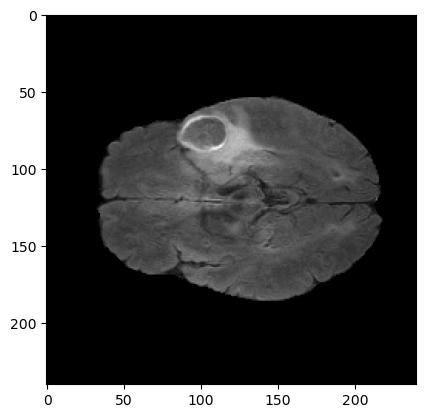

<class 'numpy.ndarray'>


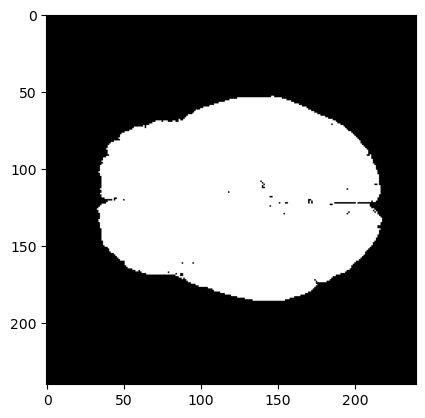

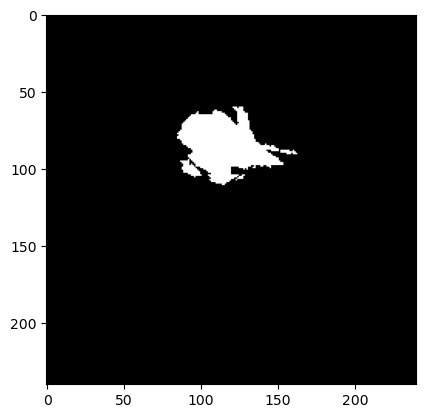

In [131]:
image = glioma_images[1,60,:,:,0]
mask = glioma_masks[1,60,:,:,:]
sample = Extraction(image,mask,1)
mask_m = sample.merge_masks2(glioma_masks[1,60,:,:,:])
print(image.shape)
plt.imshow(image,cmap="gray")
plt.show()
_,image_bin= cv2.threshold(image, 0,255,cv2.THRESH_BINARY)
print(type(image_bin))

plt.imshow(image_bin,cmap="gray")
plt.show()
plt.imshow(mask_m,cmap="gray")
plt.show()

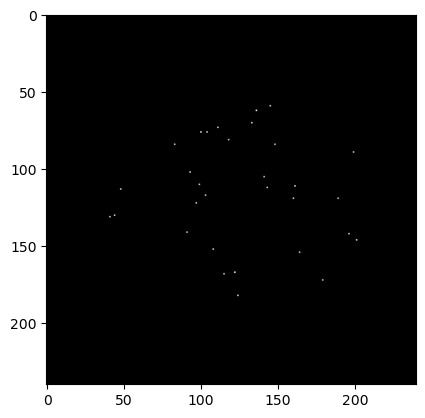

(240, 240) (240, 240)
float64 uint8


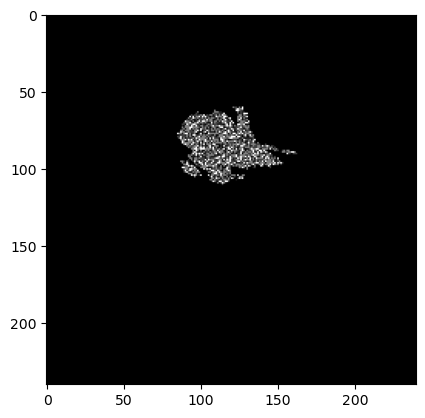

1.0


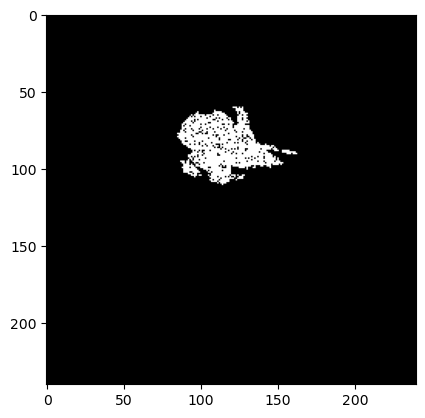

1.0


In [162]:
np.set_printoptions(threshold=np.inf, linewidth=150)
noise_mask = cv2.bitwise_and(noise,image_bin)
plt.imshow(noise_mask, cmap="gray")
plt.show()
print(noise.shape,mask_m.shape)
print(noise.dtype,mask_m.dtype)
noise_mask_mask = cv2.bitwise_and(noise,mask_m.astype(np.float64))
_,noisy_mask_bin= cv2.threshold(noise_mask_mask, 0.1,1,cv2.THRESH_BINARY)
plt.imshow(noise_mask_mask, cmap="gray")
plt.show()
print(np.amax(noise_mask_mask))
plt.imshow(noisy_mask_bin, cmap="gray")
plt.show()
print(np.amax(noise_mask_mask))

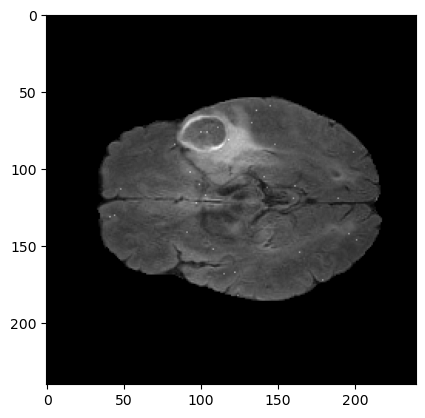

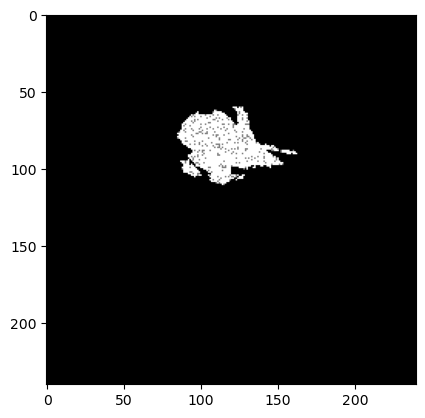

In [165]:
noisy_glioma_image = image + noise_mask

plt.imshow(noisy_glioma_image,cmap = "gray" )
plt.show()
final_noise_mask= mask_m  + noisy_mask_bin
plt.imshow(final_noise_mask,cmap = "gray" )
plt.show()

In [178]:
features_sets = []
feature_dict = {}
image_sitk = sitk.GetImageFromArray(image)
noisyg_image_sitk = sitk.GetImageFromArray(noisy_glioma_image)

# Load the segmentation mask using SimpleITK
mask_sitk= sitk.GetImageFromArray(mask)
print(noisy_glioma_image.shape)
print(final_noise_mask.shape)
noisy_mask_sitk= sitk.GetImageFromArray(final_noise_mask)


# Configure the PyRadiomics feature extractor using default parameters
extractor = featureextractor.RadiomicsFeatureExtractor()
#extractor2 = featureextractor.RadiomicsFeatureExtractor()

#print(noisy_glioma_image.size,noisy_mask_sitk.size)
features = extractor.execute(image_sitk, mask_sitk)
#features_noise= extractor2.execute(noisyg_image_sitk ,noisy_mask_sitk)
#GSDEV=extractor.getSmallDependenceEmphasisFeatureValue()
#features_sets.append(features)

dict_keys = list(features.keys())
useful_features = dict_keys[24:115]
# print(useful_feature)
print
#print(dict_keys)
print
print

fscore= pd.DataFrame(index = useful_features, columns=["Originnal","Noise", "Diff"])
#fscore.index=useful_features
#print(fscore)



for idx in range(len(useful_features)):
    #print(features[useful_features[idx]])
    fscore.iloc[idx,0] = features[useful_features[idx]]
    fscore.iloc[idx,1] = features_noise[useful_features[idx]]
print("fscore",fscore)


for feature_name, value in features.items():
    print(f"{feature_name}: {value}")
    feature_dict[feature_name]=value



(240, 240)
(240, 240)


RuntimeError: Exception thrown in SimpleITK LabelStatisticsImageFilter_Execute: D:\a\1\sitk\Code\BasicFilters\src\sitkImageFilter.cxx:38:
sitk::ERROR: Input "labelImage" for "LabelStatisticsImageFilter" has dimension of 3 which does not match the primary input's dimension of 2!

In [ ]:
import numpy as np
from radiomics import featureextractor
import SimpleITK as sitk

features_sets = []
for i in range(4):
    # Convert the NumPy array to a SimpleITK image
    image_array = glioma_slices_images[:,:,:,i]
    image = sitk.GetImageFromArray(image_array)

    # Load the segmentation mask using SimpleITK
    mask = sitk.GetImageFromArray(summed_masks)

    # Configure the PyRadiomics feature extractor using default parameters
    extractor = featureextractor.RadiomicsFeatureExtractor()

    # Extract radiomic features
    features = extractor.execute(image, mask)
    features_sets.append(features)
    # Print the extracted features
    for feature_name, value in features.items():
        print(f"{feature_name}: {value}")